Plate detection and recognition

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD


2024-01-21 19:09:33.680579: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 19:09:34.236313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 19:09:34.236540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 19:09:34.325625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 19:09:34.519181: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 19:09:34.520612: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show_image(img, color=False):
    if color:
        plt.imshow(img)
    else:
        plt.imshow(img, 'gray')

Prosecna visina: 89.08
Prosecna sirina: 287.82
Prosecan aspect ratio: 3.25


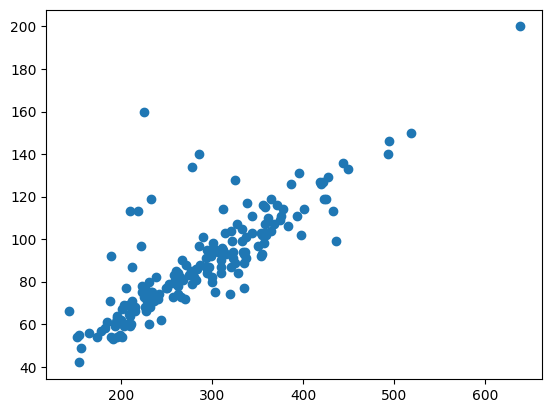

In [3]:
positive_images = []
negative_images = []

folder_path = '../datasets/train/'

aspect_ratios = []
widths = []
heights = []

for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = load_image(img_path)
    if 'plate' in img_name:
        positive_images.append(img)
        width = img.shape[1]
        height = img.shape[0]
        heights.append(height)
        widths.append(width)
        aspect_ratios.append(width/height)

    elif 'neg' in img_name:
        negative_images.append(img)

print(f'Prosecna visina: {sum(heights)/len(positive_images):.2f}')
print(f'Prosecna sirina: {sum(widths)/len(positive_images):.2f}')
avg_aspect_ratio = sum(aspect_ratios) / len(aspect_ratios)
print(f'Prosecan aspect ratio: {avg_aspect_ratio:.2f}')
plt.scatter(widths, heights)
plt.show()


In [4]:
new_width = 200
new_height = int(new_width / avg_aspect_ratio)

for i, img in enumerate(positive_images):
    positive_images[i] = cv2.resize(img, (new_width, new_height))

for i, img in enumerate(negative_images):
    negative_images[i] = cv2.resize(img, (new_width, new_height))


In [5]:
positive_features = []
negative_features = []
labels = []

nbins = 9
cell_size = (8, 8)
block_size = (3, 3)

hog = cv2.HOGDescriptor(_winSize=(new_width // cell_size[1] * cell_size[1], 
                                  new_height // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

for img in positive_images:
    positive_features.append(hog.compute(img))
    labels.append(1)

for img in negative_images:
    negative_features.append(hog.compute(img))
    labels.append(0)

positive_features = np.array(positive_features)
negative_features = np.array(negative_features)
x = np.vstack((positive_features, negative_features))
y = np.array(labels)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)

y_train_pred = svm.predict(x_train)
y_val_pred = svm.predict(x_val)
print(f'Train accuracy:{accuracy_score(y_train, y_train_pred)}')
print(f'Validation accuracy:{accuracy_score(y_val, y_val_pred)}')


Train accuracy:1.0
Validation accuracy:0.9857142857142858


In [7]:
def evaluate_window(window):
    features = hog.compute(window).reshape(1, -1)
    return svm.predict_proba(features)[0][1]

In [8]:
def detectPlate(image, step, window_size):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = evaluate_window(window)
                if score > best_score:
                    best_score = score
                    best_window = (y, x)
    return best_score, best_window


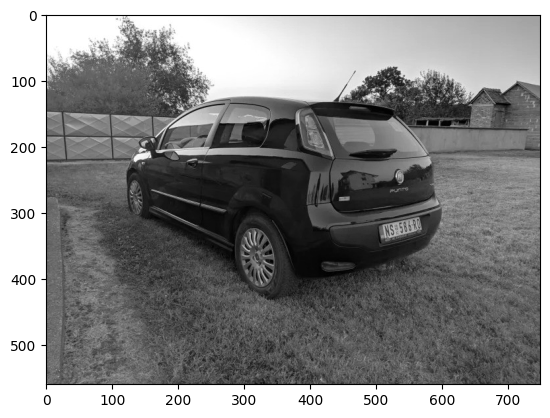

In [9]:
img = load_image('/home/stefan/Downloads/test5.jpg')
show_image(img)

necemo koristiti cv2.pyrDown(image)


In [10]:
def gaussian_pyramid(image, num_levels=3, ksize=(5,5)):
    images = []
    images.append(image)

    for i in range(num_levels-1):
        image = cv2.GaussianBlur(image, sigmaX=0, ksize=ksize)
        width = int(image.shape[1] / 1.3)
        height = int(image.shape[0] / 1.3)
        image = cv2.resize(image, (width, height))
        images.append(image)

    return images

0.13576282531741993


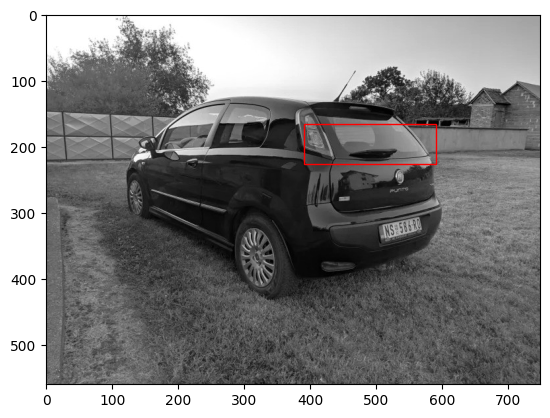

0.3748370705838315


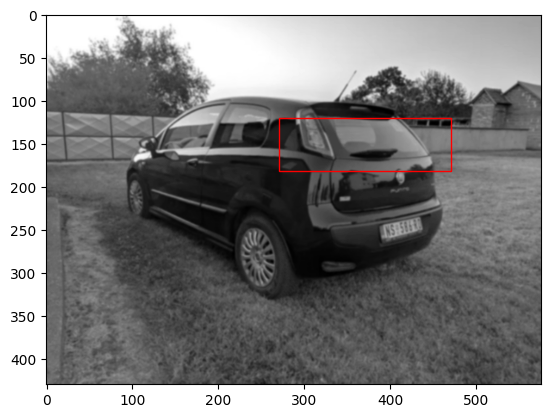

0.07194481474967111


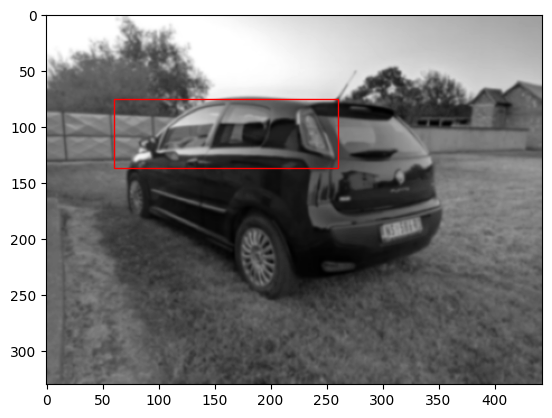

0.0766867320084286


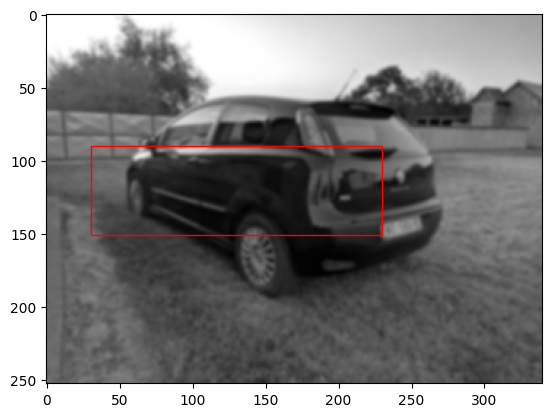

0.014889336602691441


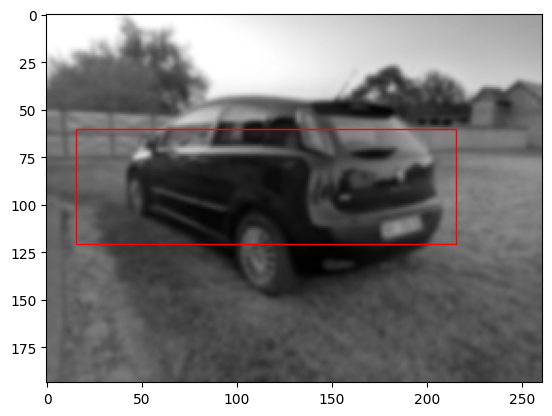

In [11]:
images = gaussian_pyramid(img, num_levels=5)
boxes = []
scores = []
for img in images:  
    score, window = detectPlate(img, 15, (new_width, new_height))
    y, x = window
    x2 = x + new_width
    y2 = y + new_height
    window2 = (x, y, x2, y2)
    scores.append(score)
    boxes.append(window2)
    print(score)
    rect = plt.Rectangle((x, y), new_width, new_height, edgecolor='r', facecolor='none')
    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(rect)
    plt.show()


In [12]:
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def dilate(image, kernel_shape=(3, 3), iter=1):
    kernel = np.ones(kernel_shape)
    return cv2.dilate(image, kernel, iterations=iter)

def erode(image, kernel_shape=(3, 3), iter=1):
    kernel = np.ones(kernel_shape)
    return cv2.erode(image, kernel, iterations=iter)

def resize_region(region, shape=(28, 28)):
    return cv2.resize(region, shape, interpolation=cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

In [42]:
def select_roi_test(image_orig, image_bin):
    image_bin2 = erode(image_bin, (4, 1), 1)        # da bih spojio kvacice
    contours, hierarchy = cv2.findContours(image_bin2.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = []
    regions_array = []
    y_sub = 4
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 150 and h < 100 and h > 20 and w > 5 and w < 100:
            y +=y_sub
            h -= 2 * y_sub
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [14]:
def select_roi_train(image_orig, image_bin):
    image_bin2 = erode(image_bin, (3, 1), 2)        # da bih spojio kvacice
    contours, hierarchy = cv2.findContours(image_bin2.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = []
    regions_array = []
    y_sub = 4
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 700 and h < 100 and h > 40 and w > 10:
            y +=y_sub
            h -= 2 * y_sub
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

In [15]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_cnn(output_size):
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size = (2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation = 'relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(output_size, activation='softmax'))
    
    cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return cnn

def train_cnn(cnn, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)

    callbacks = [
             EarlyStopping(patience=2)
    ]
    
    print("\nTraining started...")
    history = cnn.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=1, shuffle=True, callbacks=callbacks)
    print("\nTraining completed...")
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label='Training loss')
    plt.show()
    return cnn

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

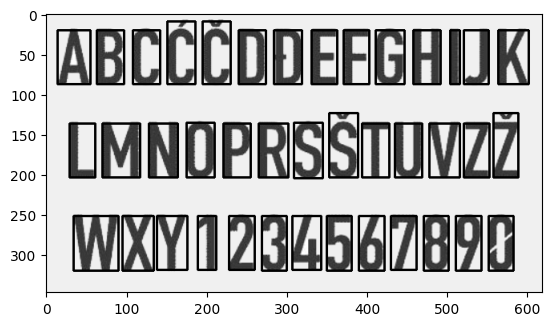

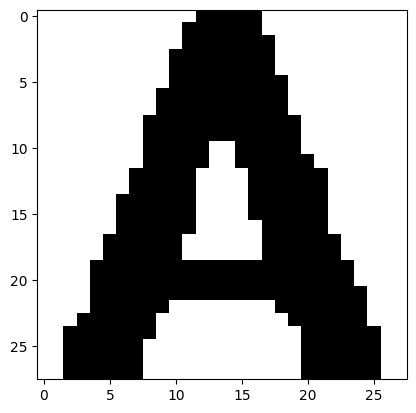

In [16]:

img = load_image('/home/stefan/Documents/PROJEKTI/plate-detection-and-recognition/datasets/plate_font.png')
img_bin = image_bin(img)
selected_img, sorted_regions = select_roi_train(img.copy(), img_bin)
show_image(selected_img)
plt.show()
show_image(sorted_regions[0])


Training started...
Epoch 1/100
40/40 [==============================] - 2s 8ms/step - loss: 3.7993 - accuracy: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 0s 8ms/step - loss: 3.7129 - accuracy: 0.0250
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: 3.6666 - accuracy: 0.1000
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 3.6021 - accuracy: 0.1000
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 3.3791 - accuracy: 0.1000
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 3.1126 - accuracy: 0.1750
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 2.5488 - accuracy: 0.3750
Epoch 8/100
40/40 [==============================] - 0s 11ms/step - loss: 2.3096 - accuracy: 0.3500
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 1.5681 - accuracy: 0.5500
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 1.3375 

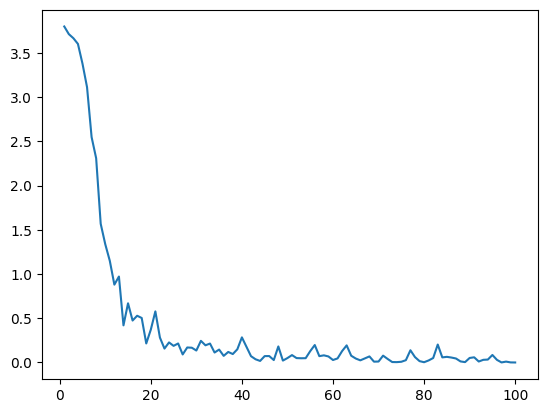

In [17]:
alphabet = ['A', 'L', 'W', 'B', 'M', 'X', 'C', 'N', 'Y', 'Ć', 'O', '1', 'Č', 'P', '2', 'D', 'R', '3', 'Đ', '4', 'S', 'E', '5', 'Š', 'F', '6', 'T', 'G', '7', 'U', 'H', '8', 'V', 'I', '9', 'Z', 'J', '0', 'Ž', 'K']
# inputs = prepare_for_ann(sorted_regions)
outputs = convert_output(alphabet)
cnn = create_cnn(output_size=len(alphabet))
prep = []
for region in sorted_regions:
    prep.append(scale_to_range(region))
cnn = train_cnn(cnn, prep, outputs, epochs=100)

In [18]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [19]:
result = cnn.predict(np.array(sorted_regions, np.float32))
print(result)
print("\n")
print(display_result(result, alphabet))

2/2 [==============================] - 0s 7ms/step
[[0.99999994 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99999994 0.         ... 0.         0.         0.        ]
 [0.         0.         0.99999994 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999994 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99999994 0.        ]
 [0.         0.         0.         ... 0.         0.         0.99999994]]


['A', 'L', 'W', 'B', 'M', 'X', 'C', 'N', 'Y', 'Ć', 'O', '1', 'Č', 'P', '2', 'D', 'R', '3', 'Đ', '4', 'S', 'E', '5', 'Š', 'F', '6', 'T', 'G', '7', 'U', 'H', '8', 'V', 'I', '9', 'Z', 'J', '0', 'Ž', 'K']


1/1 [==============================] - 0s 114ms/step
['A', 'B', 'C', 'Ć', 'Č', 'D', 'Đ', 'E', 'F', 'G', 'H', 'I', 'J', 'K']


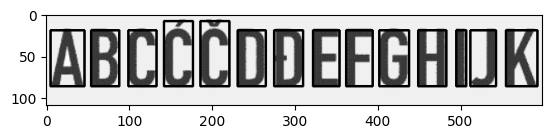

In [20]:
test = load_image('/home/stefan/Pictures/Screenshots/1.png')
test_bin = image_bin(test)
selected_img, test_regions = select_roi_train(test.copy(), test_bin)
show_image(selected_img)
test_inputs = prepare_for_ann(test_regions)
results = cnn.predict(np.array(test_regions))
print(display_result(results, alphabet))

0.9304567961462916


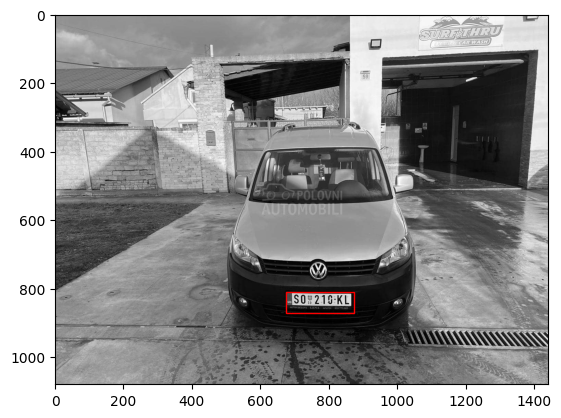

In [21]:
img = load_image('/home/stefan/Downloads/test.jpg')
show_image(img)
score, window = detectPlate(img, 15, (new_width, new_height))
y, x = window
x2 = x + new_width
y2 = y + new_height
window2 = (x, y, x2, y2)
print(score)
rect = plt.Rectangle((x, y), new_width, new_height, edgecolor='r', facecolor='none')
plt.imshow(img, cmap='gray')
plt.gca().add_patch(rect)
plt.show()

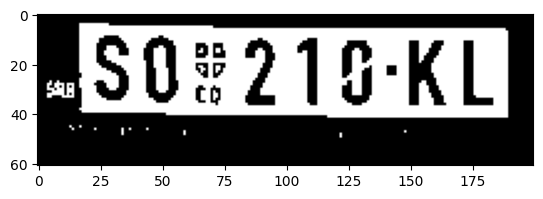

1/1 [==============================] - 0s 50ms/step
['S', '8', '2', '1', '0', 'K', 'L']


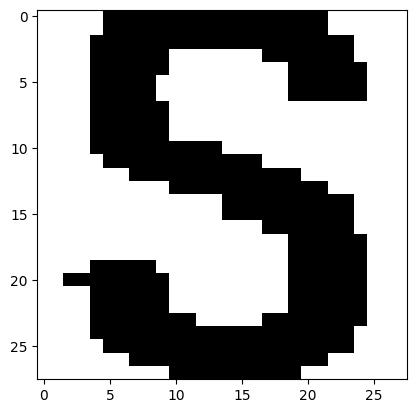

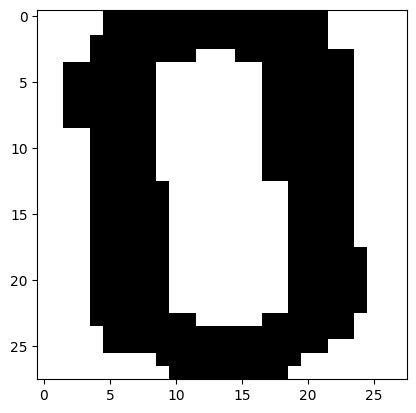

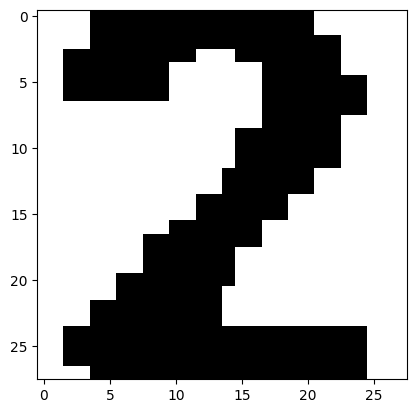

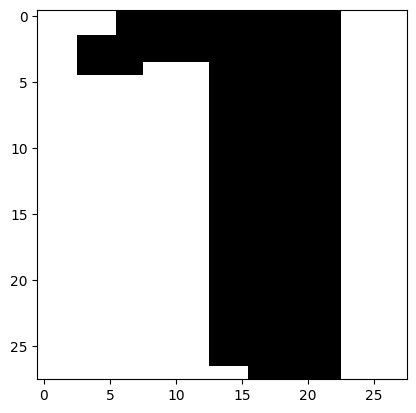

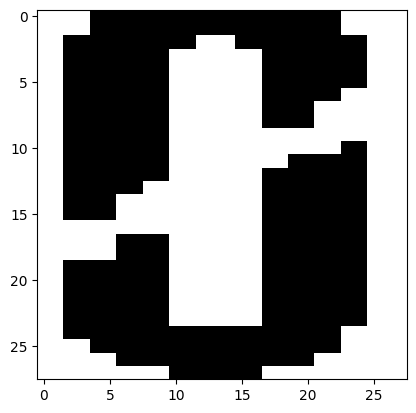

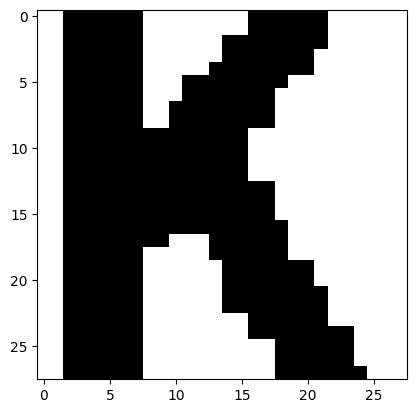

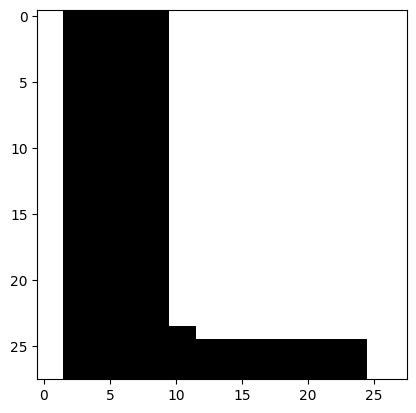

In [45]:
img = load_image('/home/stefan/Downloads/test.jpg')
plate = img[y:y+new_height, x:x+new_width]
plate_bin = image_bin(plate)
show_image(plate_bin)
plt.show()
selected_img, sorted_regions = select_roi_test(plate.copy(), plate_bin)

result = cnn.predict(np.array(sorted_regions, np.float32))
print(display_result(result, alphabet))

for region in sorted_regions:
    show_image(region)
    plt.show()